# 👖 Variational Autoencoders - Fashion-MNIST

In this notebook, we'll walk through the steps required to train your own autoencoder on the fashion MNIST dataset.

The code has been adapted from the excellent [VAE tutorial](https://keras.io/examples/generative/vae/) created by Francois Chollet, available on the Keras website.

In [ ]:
#John Rogers
#Generative AI
#Assignment 3
#12/13/2024

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm


## 0. Parameters <a name="parameters"></a>

In [ ]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 10
EPOCHS = 150
BETA = 500

## 1. Prepare the data <a name="prepare"></a>

In [ ]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

from scipy.io import loadmat

train_data = loadmat("train_32x32.mat")
test_data = loadmat("test_32x32.mat")

--2024-12-13 19:22:32--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  11.8MB/s    in 39s     

2024-12-13 19:23:11 (4.49 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2024-12-13 19:23:11--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  6.14MB/s    in 17s     

2024-12-13 19:23:29 (3.57 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [ ]:
# Preprocess the data

x_train = np.transpose(train_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_train = train_data['y'].flatten()
x_test = np.transpose(test_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_test = test_data['y'].flatten()


#Display the shape of the datasets
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")

x_train shape: (73257, 32, 32, 3)
x_test shape: (26032, 32, 32, 3)


## 2. Build the variational autoencoder <a name="build"></a>

In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Encoder
latent_dim = EMBEDDING_DIM
encoder_input = layers.Input(shape=(32, 32, 3), name="encoder_input")

x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!
x = layers.Flatten()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 32)     │            896 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 8, 8, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 4, 4, 128)      │         73,856 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2048)           │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 10)             │         20,490 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 10)             │         20,490 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 10)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 134,228 (524.33 KB)

 Trainable params: 134,228 (524.33 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Decoder

decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)

x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)

decoder_output = layers.Conv2D(3,(3, 3), strides=1, activation="sigmoid", padding="same", name="decoder_output",)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │          22,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2D)              │ (None, 32, 32, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 263,235 (1.00 MB)

 Trainable params: 263,235 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):

      if isinstance(data, tuple):
        data = data[0]
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [ ]:
# Create a variational autoencoder
def build_vae(latent_dim):
    vae = VAE(encoder, decoder)
    return vae

vae_model = build_vae(EMBEDDING_DIM)
vae_model.compile(optimizer='adam')

## 3. Train the variational autoencoder <a name="train"></a>

In [ ]:
# Compile the variational autoencoder
latent_dims = [2, 5, 10]
for dim in latent_dims:
    vae = build_vae(latent_dim=dim)
    vae.compile(optimizer='adam', loss=losses.binary_crossentropy)

In [ ]:
vae.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, x_test),
)

Epoch 1/150
733/733 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - kl_loss: 2.2978 - reconstruction_loss: 327.9716 - total_loss: 330.2694 - val_kl_loss: 4.2910 - val_loss: 312.6703 - val_reconstruction_loss: 308.3792
Epoch 2/150
733/733 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - kl_loss: 4.2079 - reconstruction_loss: 315.4585 - total_loss: 319.6664 - val_kl_loss: 5.0980 - val_loss: 311.9336 - val_reconstruction_loss: 306.8356
Epoch 3/150
733/733 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - kl_loss: 4.7216 - reconstruction_loss: 314.5070 - total_loss: 319.2286 - val_kl_loss: 5.4831 - val_loss: 311.0163 - val_reconstruction_loss: 305.5331
Epoch 4/150
733/733 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - kl_loss: 4.9341 - reconstruction_loss: 314.1581 - total_loss: 319.0922 - val_kl_loss: 5.5599 - val_loss: 311.4494 - val_reconstruction_loss: 305.8895
Epoch 5/150
733/733 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - kl_loss: 4.9679 - reconstruction_loss: 314.0509 - total_loss: 319.0187 - val_kl_loss: 5.7961 - val_loss: 311.0583 - 

## 3. Reconstruct using the variational autoencoder <a name="reconstruct"></a>

In [ ]:
# Select a subset of the test set
n_to_predict = 10
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


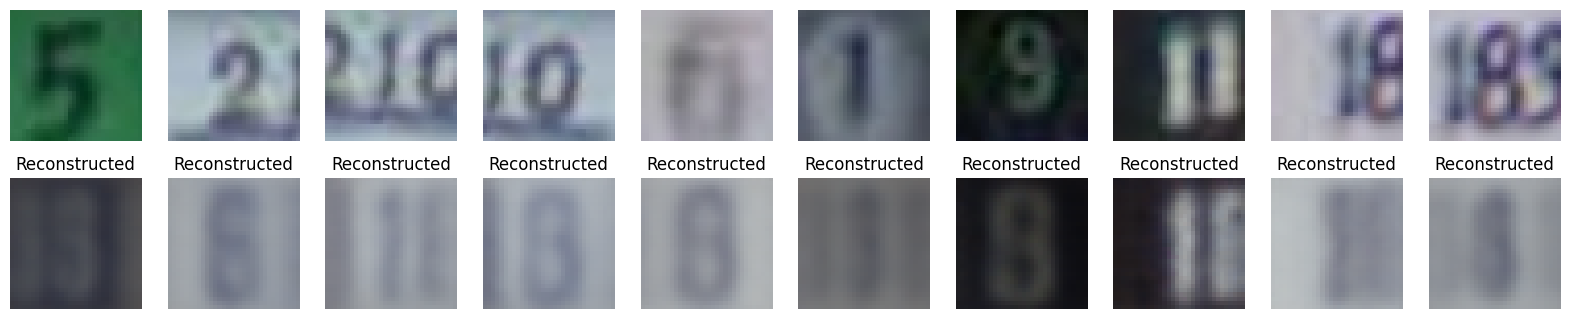

In [ ]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)

def display_images(original_images, reconstructed_images, n):
    fig, axes = plt.subplots(2, n, figsize=(20, 4))
    for i in range(n):
        # Display original
        axes[0, i].imshow(original_images[i, :, :, :])
        axes[0, i].axis("off")
        axes[1, i].set_title("Original")
        # Display reconstruction
        axes[1, i].imshow(reconstructed_images[i])
        axes[1, i].axis("off")
        axes[1, i].set_title("Reconstructed")
    plt.show()

display_images(example_images, reconstructions, n_to_predict)

## 4. Embed using the encoder <a name="encode"></a>

In [ ]:
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


In [ ]:
# Some examples of the embeddings
print(z[:10])

[[ 1.2613047   0.9974507  -1.0569782   1.6697619  -1.4641697  -0.81468636
  -0.41452396  0.17747071  0.34179735  0.5337889 ]
 [-1.1533146   0.55140924 -0.47215542 -0.79866934 -0.6864914   0.87807614
  -0.793373   -1.574178   -0.08491355 -1.6962883 ]
 [-0.9849677  -0.30394062  0.7820384   1.5717099  -2.082756   -0.26949263
  -0.1407547   0.4222397   0.7662372   1.1423483 ]
 [-0.836027    1.0606912   0.78546196  0.81224555  1.2145478   0.22266524
  -0.47818545 -0.09990692  0.38082394  0.2149949 ]
 [-0.9641055   1.177724    0.27534774 -0.58419955 -0.78774536 -0.41676357
   0.13670488 -0.13826448  0.31877744  0.7702019 ]
 [ 0.27787858 -0.71328634  1.4379611   0.76126194  0.02890608  0.5492326
  -0.18429813 -0.7475206  -0.6836294  -0.6701293 ]
 [ 2.631339    0.02589661 -1.0707757  -0.40822896  0.09442144  1.4238453
   0.61199546 -0.8106686   0.00396121  0.5411843 ]
 [ 0.9260249   1.1966715  -2.2066164  -0.8390897   1.9918957   1.4423058
   2.3269534  -0.5988866  -0.49322772 -0.5316346 ]
 [-

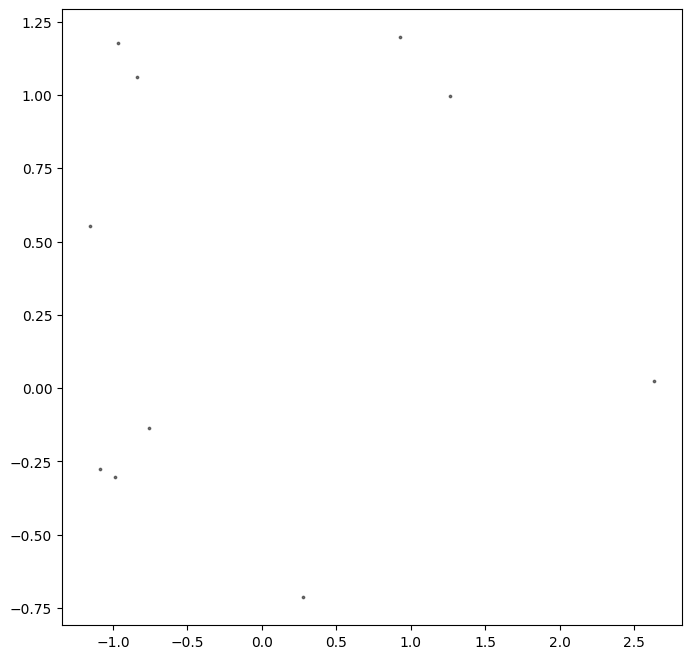

In [ ]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

## 5. Generate using the decoder <a name="decode"></a>

In [ ]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

## 6. Explore the latent space <a name="explore"></a>

In [ ]:
# Colour the embeddings by their label (clothing type - see table)
def visualize_latent_space(vae, x_test):
    #Encode test images into the latent space
    z_mean, z_log_var, reconstructions = vae.encoder(x_test)

    #Plot the latent space
    plt.figure(figsize=(8, 6))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c='blue', alpha=0.5)
    plt.title("Latent Space Representation")
    plt.xlabel("Latent Dim 1")
    plt.ylabel("Latent Dim 2")
    plt.show()

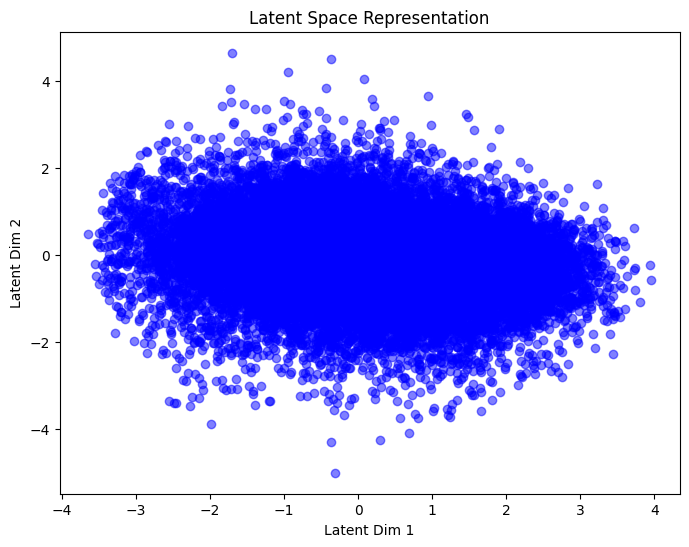

In [ ]:
 visualize_latent_space(vae, x_test)

  
Original Images: The Original Images are slightly pixelated but overall came out visible

Reconstructed Images: The Reconstructed Images are blurry and only slightly visible

Clarity: While the vae's reconstructed images are not as clear as the original's, it is still possible to make out the number despite them being blurry

Distortion:I believe that the distortion between images could be due to improvement of latent space.

Variability: For the most part, the background of the reconstructed images are consistent with the originals with only slight alterations with the exception of the very first pair.

Generalization: I think that the vae was successful as it was able to generate somewhat coherent numbers. With more training I believe that it would be able to generate better samples